In [1]:
import trenchripper as tr

import numpy as np
import pandas as pd
import seaborn as sns
import sklearn as skl
import dask.dataframe as dd
import warnings
import random
import statsmodels.api as sm

from matplotlib import pyplot as plt

import goatools
import goatools.base
from goatools.base import download_go_basic_obo
from goatools.obo_parser import GODag
from goatools.anno.gaf_reader import GafReader

random.seed(42)
np.random.seed(42)

dask_wd = "/home/de64/scratch/de64/dask"

warnings.filterwarnings(action='once',category=UserWarning)

plt.style.use('./deaton.mplstyle')

### Load Functions

In [2]:
def compute_volume(length,width): ##spherocylinder
    volume = np.pi * ((1/4)*(width**2)*(length-width) + (1/6)*(width**3))
    return volume

def search_go(ns2assoc, obodag, inv_gene_to_id, go_term):
    namespace_abbv = {"biological_process":"BP","molecular_function":"MF","cellular_component":"CC"}
    
    print("Searching for " + str(obodag[go_term].name))
    namespace = namespace_abbv[obodag[go_term].namespace]
    child_goterms = list(obodag[go_term].get_all_children())
    gene_list = [inv_gene_to_id[key] for key,val in ns2assoc[namespace].items() if go_term in val]
    for child_goterm in child_goterms:    
        gene_list += [inv_gene_to_id[key] for key,val in ns2assoc[namespace].items() if child_goterm in val]
    gene_list = sorted(list(set(gene_list)))
    return gene_list

def get_std(plate_data,plate_map,plate_map_std_dict):
    standard_vals = []
    standard_signal = []
    for key,val in plate_map_std_dict.items():
        selected_data = np.array(plate_data[plate_map==key]).flatten()
        selected_data = selected_data[~np.isnan(selected_data)]
        working_standard_vals = [val for i in range(len(selected_data))]
        standard_vals += working_standard_vals
        standard_signal += list(selected_data)
    standard_vals = np.array(standard_vals)
    standard_signal = np.array(standard_signal)
    return standard_vals,standard_signal

def linear_regression(plate_data,plate_map,plate_map_std_dict):
    ##extract standard values
    std_vals,std_signal = get_std(plate_data,plate_map,plate_map_std_dict)
    
    ##linear regression
    reg = skl.linear_model.LinearRegression().fit(std_vals.reshape(-1,1),std_signal)
    predict = reg.predict(std_vals.reshape(-1,1))
    resid = (std_signal - predict)
    reg_uncertainty = np.sqrt(np.sum(resid**2)/(len(resid)-2))
    slope_uncertainty = reg_uncertainty/np.sqrt(np.sum((std_vals-np.mean(std_vals))**2))

    ## calculating LOQ by standard error of regression slope
    deriv = reg.coef_[0]    
    intercept = reg.intercept_
    loq = 10*(slope_uncertainty/deriv)
    print("LOQ: " + str(loq))
    
    predicted_concentrations = plate_data.apply(lambda x: (x-intercept)/deriv)
    samples_mask = ~plate_map.isin(list(plate_map_std_dict.keys()) + [np.NaN])
    all_samples_list = plate_map.values[samples_mask.values]
    all_sample_vals_list = predicted_concentrations.values[samples_mask.values]
    return all_samples_list,all_sample_vals_list

def weighted_least_squares(df,wt_row):
    df = pd.concat([df,wt_row])
    y = df['RNA/Protein']
    X = sm.add_constant(df['Instantaneous Growth Rate: Volume'])
    w = 1.0 / (df['RNA/Protein SEM']**2)

    model = sm.WLS(y, X, weights=w)
    fit   = model.fit()

    # grab params and their standard errors
    intercept, slope = fit.params
    int_se,    sl_se = fit.bse

    results = {'Intercept':   intercept,
        'Slope':       slope,
        'Intercept SEM': int_se,
        'Slope SEM':     sl_se}
    results = pd.Series(results)
    return results

## Figure S12A

### Load Data

In [3]:
ss_estimators_df = pd.read_pickle("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/lDE20_Imaging/2024-01-25_lDE20_Steady_State_df_Estimators_wStats.pkl")
ss_estimators_df = ss_estimators_df.loc["Mean (Robust)"]

ss_isolate_estimators_df = pd.read_pickle("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/Translation_Knockdowns/Mother_Machine_Imaging/2024-11-01_Steady_State_df_Estimators_wStats.pkl")
ss_isolate_estimators_df = ss_isolate_estimators_df.loc["Mean (Robust)"]

In [4]:
final_columns = ["Gene","Category"]
control_categories = ['OnlyPlasmid', 'NoTarget']
params_of_interest = ['Length','Width','Instantaneous Growth Rate: Volume']
prolif_params = []
param_names = [r"Length ($ \mu m $)",r"Width ($ \mu m $)",r"Volume ($ \mu m^{3} $)"]
param_ranges = [(0.,10.),(1.3,1.6),(0.,2.2)]
param_ticks = [[0,2,4,6,8,10],[1.3,1.4,1.5,1.6],[0.,1.,2.]]

min_n_observations = 8
## minimum set from https://stats.stackexchange.com/questions/33300/determining-sample-size-necessary-for-bootstrap-method-proposed-method
sem_ratio_thr_ss = 0.2

final_column_df = ss_estimators_df.reset_index().groupby("oDEPool7_id").first()[final_columns]
ss_estimators_df["SEM/Location"] = (np.sqrt(ss_estimators_df["Estimator Variance"])/ss_estimators_df["Value"]).copy()
ss_estimators_df = ss_estimators_df[ss_estimators_df["SEM/Location"]<sem_ratio_thr_ss]
ss_estimators_df = ss_estimators_df.reset_index().set_index(["oDEPool7_id"])

##hack to get both observatoins and proliferating observations (was broken)
observation_df = ss_estimators_df[ss_estimators_df["Variable(s)"] == "Length"][["N Observations"]]
observation_df = observation_df.join(ss_estimators_df[ss_estimators_df["Variable(s)"] == "Delta time (s)"][["N Observations Proliferating"]])

variance_estimators_df = ss_estimators_df[["Variable(s)","Estimator Variance"]]
ss_estimators_df = ss_estimators_df[["Variable(s)","Value"]]
ss_estimators_df = ss_estimators_df.pivot(columns=["Variable(s)"])
variance_estimators_df = variance_estimators_df.pivot(columns=["Variable(s)"])

ss_estimators_df.columns = ss_estimators_df.columns.droplevel(0)
variance_estimators_df.columns = variance_estimators_df.columns.droplevel(0)
variance_estimators_df.columns = [column + " SEM" for column in variance_estimators_df.columns]
variance_estimators_df = np.sqrt(variance_estimators_df)
ss_estimators_df = ss_estimators_df.join(observation_df,on=['oDEPool7_id'])
ss_estimators_df = ss_estimators_df.join(variance_estimators_df,on=['oDEPool7_id'])

ss_estimators_df = ss_estimators_df[ss_estimators_df["N Observations"]>=min_n_observations]
ss_estimators_df["Instantaneous Growth Rate: Volume"] = ss_estimators_df["Instantaneous Growth Rate: Volume"]/np.log(2)
ss_estimators_df["Instantaneous Growth Rate: Volume SEM"] = ss_estimators_df["Instantaneous Growth Rate: Volume SEM"]/np.log(2)
ss_estimators_df = ss_estimators_df.join(final_column_df)
ss_estimators_df = ss_estimators_df.dropna(subset=params_of_interest)

##import isolates

final_columns = ["Condition","Category"]
control_categories = ["Control"]

final_isolate_column_df = ss_isolate_estimators_df.reset_index().groupby("Condition Index").first()[final_columns]
ss_isolate_estimators_df["SEM/Location"] = (np.sqrt(ss_isolate_estimators_df["Estimator Variance"])/ss_isolate_estimators_df["Value"]).copy()
ss_isolate_estimators_df = ss_isolate_estimators_df[ss_isolate_estimators_df["SEM/Location"]<sem_ratio_thr_ss]
ss_isolate_estimators_df = ss_isolate_estimators_df.reset_index().set_index(["Condition Index"])

##hack to get both observatoins and proliferating observations (was broken)
isolate_observation_df = ss_isolate_estimators_df[ss_isolate_estimators_df["Variable(s)"] == "Length"][["N Observations"]]

isolate_variance_estimators_df = ss_isolate_estimators_df[["Variable(s)","Estimator Variance"]]
ss_isolate_estimators_df = ss_isolate_estimators_df[["Variable(s)","Value"]]
ss_isolate_estimators_df = ss_isolate_estimators_df.pivot(columns=["Variable(s)"])
isolate_variance_estimators_df = isolate_variance_estimators_df.pivot(columns=["Variable(s)"])

ss_isolate_estimators_df.columns = ss_isolate_estimators_df.columns.droplevel(0)
isolate_variance_estimators_df.columns = isolate_variance_estimators_df.columns.droplevel(0)
isolate_variance_estimators_df.columns = [column + " SEM" for column in isolate_variance_estimators_df.columns]
isolate_variance_estimators_df = np.sqrt(isolate_variance_estimators_df)
ss_isolate_estimators_df = ss_isolate_estimators_df.join(isolate_observation_df,on=['Condition Index'])
ss_isolate_estimators_df = ss_isolate_estimators_df.join(isolate_variance_estimators_df,on=['Condition Index'])

ss_isolate_estimators_df = ss_isolate_estimators_df[ss_isolate_estimators_df["N Observations"]>=min_n_observations]
ss_isolate_estimators_df["Instantaneous Growth Rate: Volume"] = ss_isolate_estimators_df["Instantaneous Growth Rate: Volume"]/np.log(2)
ss_isolate_estimators_df["Instantaneous Growth Rate: Volume SEM"] = ss_isolate_estimators_df["Instantaneous Growth Rate: Volume SEM"]/np.log(2)
ss_isolate_estimators_df = ss_isolate_estimators_df.join(final_isolate_column_df)
ss_isolate_estimators_df = ss_isolate_estimators_df.dropna(subset=params_of_interest)

### Adding Volumes
- Skipping errors for now

In [5]:
ss_estimators_df["Volume"] = compute_volume(ss_estimators_df["Length"],ss_estimators_df["Width"])
ss_isolate_estimators_df["Volume"] = compute_volume(ss_isolate_estimators_df["Length"],ss_isolate_estimators_df["Width"])

# ##removing controls
control_categories = ['OnlyPlasmid', 'NoTarget']
ss_estimators_df_controls_only = ss_estimators_df[ss_estimators_df["Category"].isin(control_categories)]
control_categories = ["Control"]
ss_estimators_df = ss_estimators_df[~ss_estimators_df["Category"].isin(control_categories)]

In [6]:
infA_sgrnaid = 20899
pheT_sgrnaid = 23961
rplL_sgrnaid = 702
wt_sgrnaid = 29672
# Define a custom palette, style consistent with rest of figure
strain_pallette = {'WT':(0.12156862745098039, 0.4666666666666667, 0.7058823529411765), \
                   'EV':(0.12156862745098039, 0.4666666666666667, 0.7058823529411765), \
                   'tufA':(1.0, 0.4980392156862745, 0.054901960784313725), \
                   'rplL':(0.7901960784313726, 0.7019607843137254, 0.8705882352941177), \
                   'infA':(0.8874509803921569, 0.40705882352941175, 0.40980392156862744), \
                   'pheT':(1.0, 0.4980392156862745, 0.054901960784313725), \
                   'fusA':(0.5803921568627451, 0.403921568627451, 0.7411764705882353),\
                   r'$p_{AHL}$-fusA': (0.5803921568627451, 0.403921568627451, 0.7411764705882353),\
                   'fusA*':(0.5803921568627451, 0.403921568627451, 0.7411764705882353)}

## infA
infA_df = ss_estimators_df[ss_estimators_df["Gene"]=="infA"]
## pheT
pheT_df = ss_estimators_df[ss_estimators_df["Gene"]=="pheT"]
## rplL
rplL_df = ss_estimators_df[ss_estimators_df["Gene"]=="rplL"]
## controls
wt_df = ss_estimators_df_controls_only.loc[[wt_sgrnaid]]

## isolates
non_fusA_isolate_df = ss_isolate_estimators_df.loc[[9,10,11,12]]
non_fusA_isolate_df["Color"] = non_fusA_isolate_df["Condition"].apply(lambda x: strain_pallette[x])

all_fusA_isolate_df = ss_isolate_estimators_df.loc[[0,1,2,3,4,5,6,7,8]]
all_fusA_isolate_df["Color"] = [(0.5803921568627451, 0.403921568627451, 0.7411764705882353) for i in range(9)]
all_fusA_isolate_df["Gene"] = "fusA"

fusA_isolate_df = ss_isolate_estimators_df.loc[[1,2,3,4,5,6,7,8]]
fusA_isolate_df["Color"] = [(0.5803921568627451, 0.403921568627451, 0.7411764705882353) for i in range(8)]
fusA_isolate_df["Gene"] = "fusA"

uninduced_fusA_isolate_df = ss_isolate_estimators_df.loc[[0]]
uninduced_fusA_isolate_df["Color"] = [(0.5803921568627451, 0.403921568627451, 0.7411764705882353) for i in range(1)]
uninduced_fusA_isolate_df["Gene"] = "fusA"

pheT_df["Ribo Type"] = "tRNA Synthetase"
all_fusA_isolate_df["Ribo Type"] = "Ribosome"

infA_growth_volume_df = non_fusA_isolate_df[non_fusA_isolate_df["Condition"]=="infA"]
pheT_growth_volume_df = non_fusA_isolate_df[non_fusA_isolate_df["Condition"]=="pheT"]
rplL_growth_volume_df = non_fusA_isolate_df[non_fusA_isolate_df["Condition"]=="rplL"]
EV_growth_volume_df = non_fusA_isolate_df[non_fusA_isolate_df["Condition"]=="EV"]

/tmp/ipykernel_11893/446744041.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheT_df["Ribo Type"] = "tRNA Synthetase"


### Loading RNA/Protein Samples

In [7]:
def get_sample_idx(sample_name_list):
    sample_idx = []
    for sample_name in sample_name_list:
        strain,replicate = sample_name.split("\n")
        replicate = int(replicate[1:])
        sample_idx.append((strain,replicate))
    return sample_idx

Protein_data_plate_1 = pd.read_excel("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/Translation_Knockdowns/RNA_Protein_Set_2/Protein_Plate_1.xlsx",skiprows=0,index_col=0,usecols=range(0,13))
Protein_data_plate_2 = pd.read_excel("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/Translation_Knockdowns/RNA_Protein_Set_2/Protein_Plate_2.xlsx",skiprows=0,index_col=0,usecols=range(0,13))
Protein_data_1 = pd.concat([Protein_data_plate_1,Protein_data_plate_2]).reset_index(drop=True)

RNA_data_plate_1 = pd.read_excel("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/Translation_Knockdowns/RNA_Protein_Set_2/RNA_Plate_1.xlsx",skiprows=0,index_col=0,usecols=range(0,13))
RNA_data_plate_2 = pd.read_excel("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/Translation_Knockdowns/RNA_Protein_Set_2/RNA_Plate_2.xlsx",skiprows=0,index_col=0,usecols=range(0,13))
RNA_data_1 = pd.concat([RNA_data_plate_1,RNA_data_plate_2]).reset_index(drop=True)

Protein_plate_map_standard_dict = pd.read_excel("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/Translation_Knockdowns/RNA_Protein_Set_2/Protein_Plate_Map_1.xlsx",skipfooter=11,index_col=0,usecols=range(2))['Concentrations (ug/mL)'].to_dict()
RNA_plate_map_standard_dict = pd.read_excel("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/Translation_Knockdowns/RNA_Protein_Set_2/RNA_Plate_Map_1.xlsx",skipfooter=9,index_col=0,usecols=range(2))['Concentrations (ng/ul)'].to_dict()

Protein_plate_map_1 = pd.read_excel("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/Translation_Knockdowns/RNA_Protein_Set_2/Protein_Plate_Map_1.xlsx",skiprows=9,index_col=0,usecols=range(13))
Protein_plate_map_2 = pd.read_excel("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/Translation_Knockdowns/RNA_Protein_Set_2/Protein_Plate_Map_2.xlsx",skiprows=9,index_col=0,usecols=range(13))
Protein_plate_map_merged_1 = pd.concat([Protein_plate_map_1,Protein_plate_map_2]).reset_index(drop=True)
Protein_plate_map_merged_1.columns = Protein_plate_map_merged_1.columns.astype(int)

RNA_plate_map_1 = pd.read_excel("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/Translation_Knockdowns/RNA_Protein_Set_2/RNA_Plate_Map_1.xlsx",skiprows=9,index_col=0,usecols=range(13))
RNA_plate_map_2 = pd.read_excel("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/Translation_Knockdowns/RNA_Protein_Set_2/RNA_Plate_Map_2.xlsx",skiprows=9,index_col=0,usecols=range(13))
RNA_plate_map_merged_1 = pd.concat([RNA_plate_map_1,RNA_plate_map_2]).reset_index(drop=True)
RNA_plate_map_merged_1.columns = RNA_plate_map_merged_1.columns.astype(int)

protein_samples_list_1,protein_sample_vals_list_1 = linear_regression(Protein_data_1,Protein_plate_map_merged_1,Protein_plate_map_standard_dict)
RNA_samples_list_1,RNA_sample_vals_list_1 = linear_regression(RNA_data_1,RNA_plate_map_merged_1,RNA_plate_map_standard_dict)

protein_samples_idx_1 = get_sample_idx(protein_samples_list_1)
Protein_output_df_1 = pd.DataFrame(protein_sample_vals_list_1,index=pd.MultiIndex.from_tuples(protein_samples_idx_1,names=["Strain","Replicate"]))

RNA_output_df_1 = (pd.DataFrame(RNA_sample_vals_list_1,index=pd.MultiIndex.from_tuples(protein_samples_idx_1,names=["Strain","Replicate"]))/2)*20
RNA_prot_ratio_df_1 = (RNA_output_df_1/Protein_output_df_1).sort_index()

RNA_prot_ratio_df_1 = RNA_prot_ratio_df_1.reset_index().set_index(["Strain","Replicate"])

RNA_prot_ratio_df = pd.concat([RNA_prot_ratio_df_1]).sort_index()
RNA_prot_ratio_df_translation = RNA_prot_ratio_df.reset_index()
# RNA_prot_ratio_df_translation["Strain"] = RNA_prot_ratio_df_translation["Strain"].apply(lambda x: int(x[2:]))
strain_name_map = {'DE787':('WT',29672), 'DE806-0.00':(r'$p_{AHL}$-fusA',0), 'DE806-0.13':(r'$p_{AHL}$-fusA',7), 'DE806-0.20':(r'$p_{AHL}$-fusA',5),
                   'DE806-1.00':(r'$p_{AHL}$-fusA',4), 'DE814':('rplL',702), 'DE816':('infA',20899),'DE817':('pheT',23961),
                   'DE847':('rplL',694), 'DE848':('rplL',706), 'DE849':('rplL',711),'DE850':('infA',4925),
                   'DE851':('infA',4926), 'DE852':('pheT',9220), 'DE853':('infA',20903),'DE854':('pheT',23953),
                  'DE855':('pheT',23957)}

RNA_prot_ratio_df_translation["Strain Name"] = RNA_prot_ratio_df_translation["Strain"].apply(lambda x: strain_name_map[x][0])
RNA_prot_ratio_df_translation["sgRNAid/Condition"] = RNA_prot_ratio_df_translation["Strain"].apply(lambda x: strain_name_map[x][1])
RNA_prot_ratio_df_translation = RNA_prot_ratio_df_translation.drop(columns=["Strain"], axis=0)
RNA_prot_ratio_df_translation = RNA_prot_ratio_df_translation.set_index(["Strain Name","sgRNAid/Condition","Replicate"])
RNA_prot_ratio_df_translation.columns = ['RNA/Protein']

LOQ: 0.10138132764820595
LOQ: 0.2533060949322871


### Getting Beta

In [8]:
rho_conversion = 0.76
Isolate_wt_growth_rate = EV_growth_volume_df["Instantaneous Growth Rate: Volume"].iloc[0]

translation_subset = ["WT","infA","pheT",r"$p_{AHL}$-fusA","rplL"]

RNA_prot_ratio_df_translation_subset = RNA_prot_ratio_df_translation.loc[translation_subset]
RNA_Prot_data_mean = RNA_prot_ratio_df_translation_subset.groupby(["Strain Name","sgRNAid/Condition"])[["RNA/Protein"]].mean()
RNA_Prot_data_sem = RNA_prot_ratio_df_translation_subset.groupby(["Strain Name","sgRNAid/Condition"])[["RNA/Protein"]].sem()
RNA_Prot_data_agg = RNA_Prot_data_mean.join(RNA_Prot_data_sem.rename(columns={"RNA/Protein":"RNA/Protein SEM"}))

## need to construct growth, ribosome df

## part 1 - growth from multiplex data

infA_df_subset = infA_df[infA_df.index.isin(RNA_Prot_data_agg.loc["infA"].index.tolist())]
infA_df_subset.index.name = "sgRNAid/Condition"
rplL_df_subset = rplL_df[rplL_df.index.isin(RNA_Prot_data_agg.loc["rplL"].index.tolist())]
rplL_df_subset.index.name = "sgRNAid/Condition"
pheT_df_subset = pheT_df[pheT_df.index.isin(RNA_Prot_data_agg.loc["pheT"].index.tolist())]
pheT_df_subset.index.name = "sgRNAid/Condition"
# EV_df_subset = wt_df[wt_df.index.isin(RNA_Prot_data_agg.loc["WT"].index.tolist())]
# EV_df_subset.index.name = "sgRNAid/Condition"

growth_rate_df_pt1 = pd.concat([infA_df_subset,rplL_df_subset,pheT_df_subset])[["Instantaneous Growth Rate: Volume"]]

## part 2 - growth from isolate data
infA_growth_volume_df.loc[:,"sgRNAid/Condition"] = [20899]
pheT_growth_volume_df.loc[:,"sgRNAid/Condition"] = [23961]
rplL_growth_volume_df.loc[:,"sgRNAid/Condition"] = [702]
EV_growth_volume_df.loc[:,"sgRNAid/Condition"] = [29672]
uninduced_fusA_isolate_df.loc[:,"sgRNAid/Condition"] = uninduced_fusA_isolate_df.index[0]

growth_rate_df_pt2 = pd.concat([infA_growth_volume_df,pheT_growth_volume_df,rplL_growth_volume_df,EV_growth_volume_df,uninduced_fusA_isolate_df]).set_index("sgRNAid/Condition")[["Instantaneous Growth Rate: Volume"]]

RNA_Prot_and_growth_df = RNA_Prot_data_mean.join(pd.concat([growth_rate_df_pt1,growth_rate_df_pt2]),on="sgRNAid/Condition")
RNA_Prot_and_growth_df = RNA_Prot_and_growth_df.join(RNA_Prot_data_sem.rename(columns={"RNA/Protein":"RNA/Protein SEM"})).dropna()

wt_row_for_regression = RNA_Prot_and_growth_df.loc[[("WT",29672)]]
RNA_Prot_and_growth_regression = RNA_Prot_and_growth_df.loc[["infA","pheT","rplL"]].groupby("Strain Name").apply(lambda x: weighted_least_squares(x,wt_row_for_regression))

pheT_beta = RNA_Prot_and_growth_regression.loc["pheT"]["Slope"]
pheT_beta_sem = RNA_Prot_and_growth_regression.loc["pheT"]["Slope SEM"]
infA_beta = RNA_Prot_and_growth_regression.loc["infA"]["Slope"]
infA_beta_sem = RNA_Prot_and_growth_regression.loc["infA"]["Slope SEM"]
rplL_beta = RNA_Prot_and_growth_regression.loc["rplL"]["Slope"]
rplL_beta_sem = RNA_Prot_and_growth_regression.loc["rplL"]["Slope SEM"]

fusA_delta_R = (RNA_Prot_data_mean.loc[("WT",29672)].iloc[0]-RNA_Prot_data_mean.loc[("$p_{AHL}$-fusA",0)].iloc[0])*rho_conversion
fusA_delta_R_sem = (np.sqrt((RNA_Prot_data_sem.loc[("WT",29672)].iloc[0]**2)+(RNA_Prot_data_sem.loc[("$p_{AHL}$-fusA",0)].iloc[0]**2)))*rho_conversion
fusA_delta_growth_rate = (Isolate_wt_growth_rate-uninduced_fusA_isolate_df["Instantaneous Growth Rate: Volume"].iloc[0]) ## SEM very low on growth
fusA_beta = fusA_delta_R/fusA_delta_growth_rate
fusA_beta_sem = fusA_delta_R_sem/fusA_delta_growth_rate

# infA_delta_R = (RNA_Prot_data_mean.loc[("WT","+")].iloc[0]-RNA_Prot_data_mean.loc[("infA","+")].iloc[0])*rho_conversion
# infA_delta_R_sem = (np.sqrt((RNA_Prot_data_sem.loc[("WT","+")].iloc[0]**2)+(RNA_Prot_data_sem.loc[("infA","+")].iloc[0]**2)))*rho_conversion
# infA_delta_growth_rate = (Isolate_wt_growth_rate-infA_growth_volume_df["Instantaneous Growth Rate: Volume"].iloc[0]) ## SEM very low on growth
# infA_beta = infA_delta_R/infA_delta_growth_rate
# infA_beta_sem = infA_delta_R_sem/infA_delta_growth_rate

# rplL_delta_R = (RNA_Prot_data_mean.loc[("WT","+")].iloc[0]-RNA_Prot_data_mean.loc[("rplL","+")].iloc[0])*rho_conversion
# rplL_delta_R_sem = (np.sqrt((RNA_Prot_data_sem.loc[("WT","+")].iloc[0]**2)+(RNA_Prot_data_sem.loc[("rplL","+")].iloc[0]**2)))*rho_conversion
# rplL_delta_growth_rate = (Isolate_wt_growth_rate-rplL_growth_volume_df["Instantaneous Growth Rate: Volume"].iloc[0]) ## SEM very low on growth
# rplL_beta = rplL_delta_R/rplL_delta_growth_rate
# rplL_beta_sem = rplL_delta_R_sem/rplL_delta_growth_rate

/tmp/ipykernel_11893/276175364.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  infA_growth_volume_df.loc[:,"sgRNAid/Condition"] = [20899]
/tmp/ipykernel_11893/276175364.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheT_growth_volume_df.loc[:,"sgRNAid/Condition"] = [23961]
/tmp/ipykernel_11893/276175364.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

### Getting Kappa

In [9]:
from scipy.optimize import curve_fit
from functools import partial
from sklearn.neighbors import KernelDensity

def Proteome_scaling(lamb, kappa, alpha, S0=2):
    return S0 * ((alpha - kappa*lamb)**-1)

def Proteome_scaling_global(lamb, S0, alpha_arr, kappa_arr):
    return S0 * ((alpha_arr - kappa_arr*lamb)**-1)

def get_kappa_stats(df,S0=2,n_bootstraps=200):

    kappa_init = 0.3
    kappa_lower_bound = -1
    kappa_upper_bound = 1
    
    alpha_init = 0.5
    alpha_lower_bound = 0
    alpha_upper_bound = 1

    Proteome_initial_guess = [kappa_init,alpha_init]
    Proteome_bounds = [(kappa_lower_bound,alpha_lower_bound),\
                               (kappa_upper_bound,alpha_upper_bound)]
    
    ## tRNA only fits
    growth_vals,volume_vals = df["Instantaneous Growth Rate: Volume"],df["Volume"]
    kappa_proteome,alpha_proteome = curve_fit(partial(Proteome_scaling, S0=S0), growth_vals, volume_vals, p0=Proteome_initial_guess, \
                                                        bounds=Proteome_bounds)[0]
    
    ## get residuals
    predicted_volumes = Proteome_scaling(growth_vals, kappa_proteome, alpha_proteome,S0=S0_from_Isolate_Fit)
    residuals = volume_vals - predicted_volumes
    
    kappa_proteome_boots = []
    
    for i in range(n_bootstraps):
        df_bootstrap = df.copy(deep=True)
    
        sampled_residuals = np.random.choice(residuals,size=len(residuals))
        residual_bootstrap_volume = predicted_volumes + sampled_residuals
        df_bootstrap["Volume"] = residual_bootstrap_volume
    
        growth_vals,volume_vals = df_bootstrap["Instantaneous Growth Rate: Volume"],df_bootstrap["Volume"]
        kappa_proteome_boot,alpha_proteome_boot = curve_fit(partial(Proteome_scaling, S0=S0), growth_vals, volume_vals, p0=Proteome_initial_guess, \
                                                        bounds=Proteome_bounds)[0]
        kappa_proteome_boots.append(kappa_proteome_boot)
    kappa_proteome_boots = np.array(kappa_proteome_boots)
    kappa_std = np.std(kappa_proteome_boots)
    return kappa_proteome,kappa_std

def get_alpha(kappa_tRNA, kappa_elong, wt_growth_rate):
    alpha = 1 + ((kappa_elong-kappa_tRNA)*wt_growth_rate)
    return alpha
    
def Proteome_scaling_global_wrapper(df, S0, kappa_tRNA, kappa_elong, wt_growth_rate=1.6):  
    growth_vals = df["Instantaneous Growth Rate: Volume"].values
    alpha = get_alpha(kappa_tRNA, kappa_elong, wt_growth_rate)
    
    tRNA_kappa_arr = (df["Ribo Type"]=="tRNA Synthetase").astype(int).values*kappa_tRNA
    elong_kappa_arr = (df["Ribo Type"]=="Ribosome").astype(int).values*kappa_elong
    kappa_arr = tRNA_kappa_arr+elong_kappa_arr

    alpha_arr_elong = (df["Ribo Type"]=="Ribosome").astype(int).values*alpha
    alpha_arr_tRNA = (df["Ribo Type"]=="tRNA Synthetase").astype(int).values
    alpha_arr = alpha_arr_elong + alpha_arr_tRNA
    
    predicted_volume = Proteome_scaling_global(growth_vals, S0, alpha_arr, kappa_arr)
    return predicted_volume

def compute_log_likelihood_and_R2_Proteome(df,volume_vals,model,S0,kappa_tRNA,kappa_elong,wt_growth_rate=1.6):    
    growth_vals = df["Instantaneous Growth Rate: Volume"].values
    alpha = get_alpha(kappa_tRNA, kappa_elong, wt_growth_rate)

    tRNA_kappa_arr = (df["Ribo Type"]=="tRNA Synthetase").astype(int).values*kappa_tRNA
    elong_kappa_arr = (df["Ribo Type"]=="Ribosome").astype(int).values*kappa_elong
    kappa_arr = tRNA_kappa_arr+elong_kappa_arr

    alpha_arr = (df["Ribo Type"]=="Ribosome").astype(int).values*alpha
    alpha_arr_tRNA = (df["Ribo Type"]=="tRNA Synthetase").astype(int).values

    alpha_arr = alpha_arr + alpha_arr_tRNA

    predicted_volume = model(growth_vals,S0,alpha_arr,kappa_arr)
    
    # Compute residuals
    residuals = volume_vals - predicted_volume

    # Maximum-likelihood estimate of variance
    N = len(volume_vals)
    SSE = np.sum(residuals**2)         # Sum of squared errors
    var_hat = SSE / N  # MLE estimate for the variance 

    # 6. Compute the (Gaussian) log-likelihood (
    log_likelihood = (
        -0.5 * N * np.log(2 * np.pi)
        -0.5 * N * np.log(var_hat)
        -0.5 * (SSE / var_hat)
    )
    print(log_likelihood)
    SST = np.sum((volume_vals-np.mean(volume_vals))**2)
    R2 = 1 - (SSE/SST)
    return log_likelihood,R2

In [10]:
S0_from_Isolate_Fit = 1.776

pheT_kappa,pheT_kappa_sem = get_kappa_stats(pheT_df,S0=S0_from_Isolate_Fit)
infA_kappa,infA_kappa_sem = get_kappa_stats(infA_df,S0=S0_from_Isolate_Fit)
rplL_kappa,rplL_kappa_sem = get_kappa_stats(rplL_df,S0=S0_from_Isolate_Fit)
fusA_kappa,fusA_kappa_sem = get_kappa_stats(fusA_isolate_df,S0=S0_from_Isolate_Fit)

### Plot

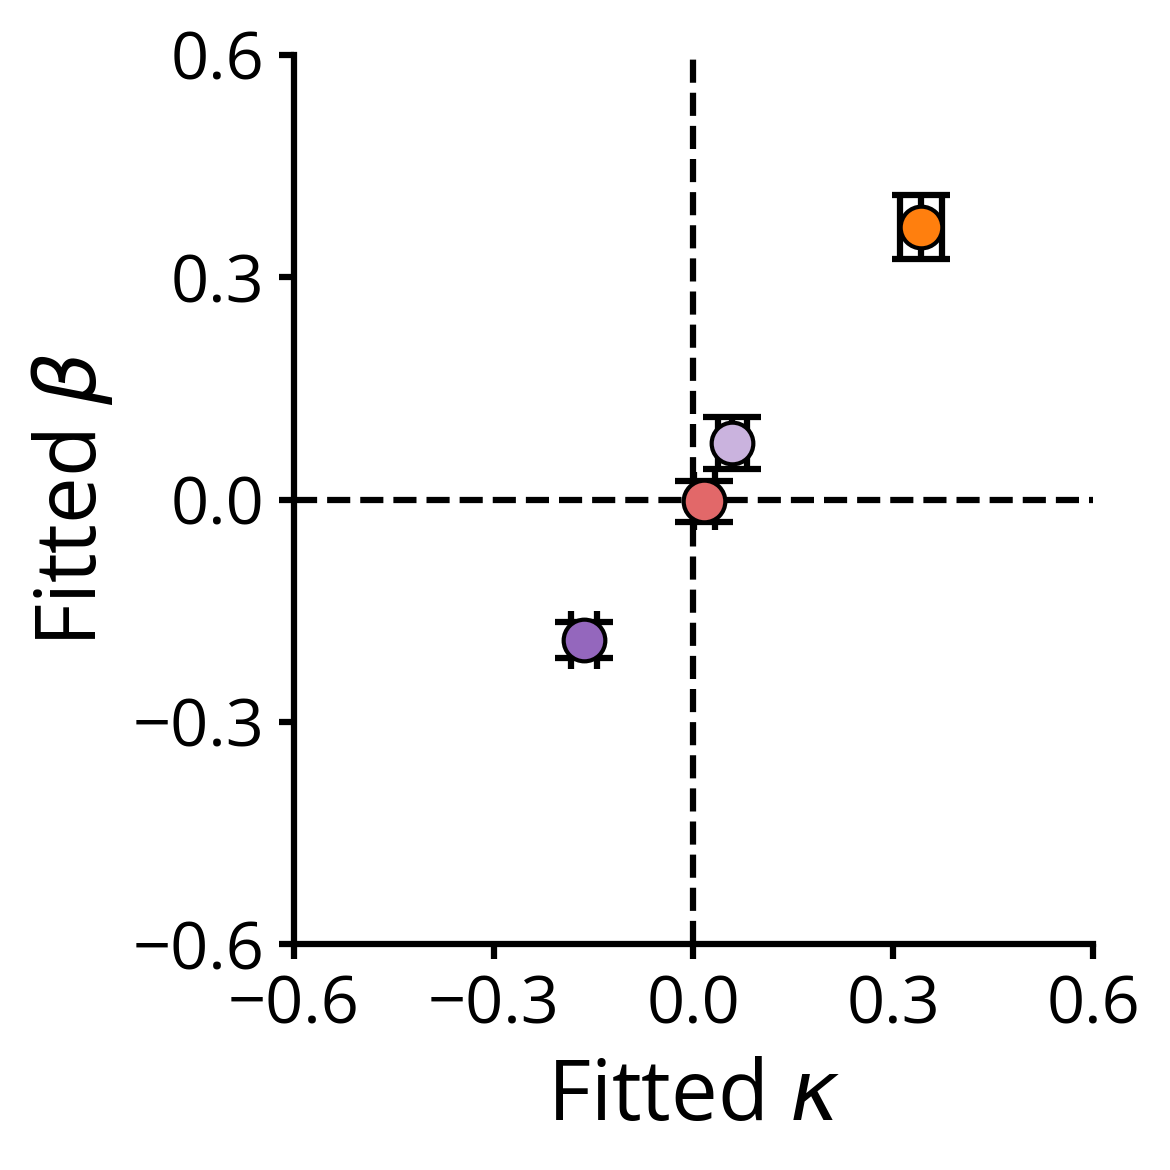

In [11]:
xy_min,xy_max = -0.6,0.6

strain_order = ["pheT","infA","rplL","fusA"]
color_list = [strain_pallette[strain] for strain in strain_order]

kappa_list = [pheT_kappa,infA_kappa,rplL_kappa,fusA_kappa]
kappa_sem_list = [pheT_kappa_sem,infA_kappa_sem,rplL_kappa_sem,fusA_kappa_sem]
beta_list = [pheT_beta,infA_beta,rplL_beta,fusA_beta]
beta_sem_list = [pheT_beta_sem,infA_beta_sem,rplL_beta_sem,fusA_beta_sem]

kappa_beta_df = pd.DataFrame({"Kappa":kappa_list,"Kappa SEM":kappa_sem_list,"Beta":beta_list,"Beta SEM":beta_sem_list,"Strain":strain_order})

# xy_linspace = np.linspace(-1,1)

fig = plt.figure(figsize=(4,4))

# Create a scatter plot with error bars
for i,gene_name in enumerate(strain_order):
    kappa_beta_selected = kappa_beta_df[kappa_beta_df["Strain"] == gene_name]

    plt.errorbar(kappa_beta_selected["Kappa"],kappa_beta_selected["Beta"],\
                 xerr=2*kappa_beta_selected["Kappa SEM"], yerr=2*kappa_beta_selected["Beta SEM"],\
                 fmt='o', ecolor='black', capsize=7, label="Data with error bars", markeredgecolor='black',\
             markerfacecolor=color_list[i],markersize=10,capthick=1.5,elinewidth=1.5)

plt.vlines(0,xy_min,xy_max,color="black",zorder=-15, linestyle= "--",linewidth=1.5)
plt.hlines(0,xy_min,xy_max,color="black",zorder=-15, linestyle= "--",linewidth=1.5)
plt.xlim(xy_min,xy_max)
plt.ylim(xy_min,xy_max)

plt.yticks([-0.6,-0.3,0,0.3,0.6],minor=False)
plt.xticks([-0.6,-0.3,0,0.3,0.6],minor=False)

plt.xlabel(r"Fitted $\kappa$",fontsize=20)
plt.ylabel(r"Fitted $\beta$",fontsize=20)

plt.tick_params(axis='both', labelsize=16, width=1.5)  # Set x-tick label size
plt.tick_params(axis='both', labelsize=16, width=1, length=3, which="minor")  # Set x-tick label size
sns.despine(top=True,right=True)
for spine in plt.gca().spines.values():
    spine.set_linewidth(1.5)

plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/S12/Kappa_Beta_Linearity.png",dpi=500,transparent=True,bbox_inches="tight")

## Figure S12B

In [12]:
def get_cross_section(width):
    cross_section = np.pi * (width/2)**2
    return cross_section

def get_per(width):
    perimeter = 2 * np.pi * (width/2)
    return perimeter

def get_sa(width,length):
    surface_area = np.pi * width * length
    return surface_area

def get_cell_vol(width,length):
    volume = np.pi * ((1/4)*(width**2)*(length-width) + (1/6)*(width**3))
    return volume

def get_length_from_width_vol(width,vol):
    length = ((4*((vol/np.pi) - (1/6)*(width**3)))/(width**2)) + width
    return length

def get_cross_section_vol_ratio(width,length):
    return get_cross_section(width)/get_cell_vol(width,length)

def get_per_vol_ratio(width,length):
    return get_per(width)/get_cell_vol(width,length)
    
def get_sa_vol_ratio(width,length):
    return get_sa(width,length)/get_cell_vol(width,length)

def get_len_vol_ratio(width,length):
    return length/get_cell_vol(width,length)

def get_len_vol_from_const_per(width,per):
    length = per/(np.pi*width)
    vol = get_cell_vol(width,length)
    return length,vol

def get_len_vol_from_const_sa(width,sa):
    length = sa/(np.pi*width)
    vol = get_cell_vol(width,length)
    return length,vol

def get_len_sa_from_const_vol(width,vol):
    length = get_length_from_width_vol(width,vol)
    sa = get_sa(width,length)
    return length,sa

In [13]:
preinduction_time = 3600*2
steady_state_time = 3600*8

lDE26_cell_cycle_cell_wall = pd.read_pickle("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/lDE26_Imaging/Raw_Cell_Width_Data.pkl")
lDE26_cell_cycle_cell_wall_ss = lDE26_cell_cycle_cell_wall[lDE26_cell_cycle_cell_wall["Mid-Cycle time (s)"]>steady_state_time]
lDE26_cell_cycle_cell_wall_pre = lDE26_cell_cycle_cell_wall[lDE26_cell_cycle_cell_wall["Mid-Cycle time (s)"]<preinduction_time]

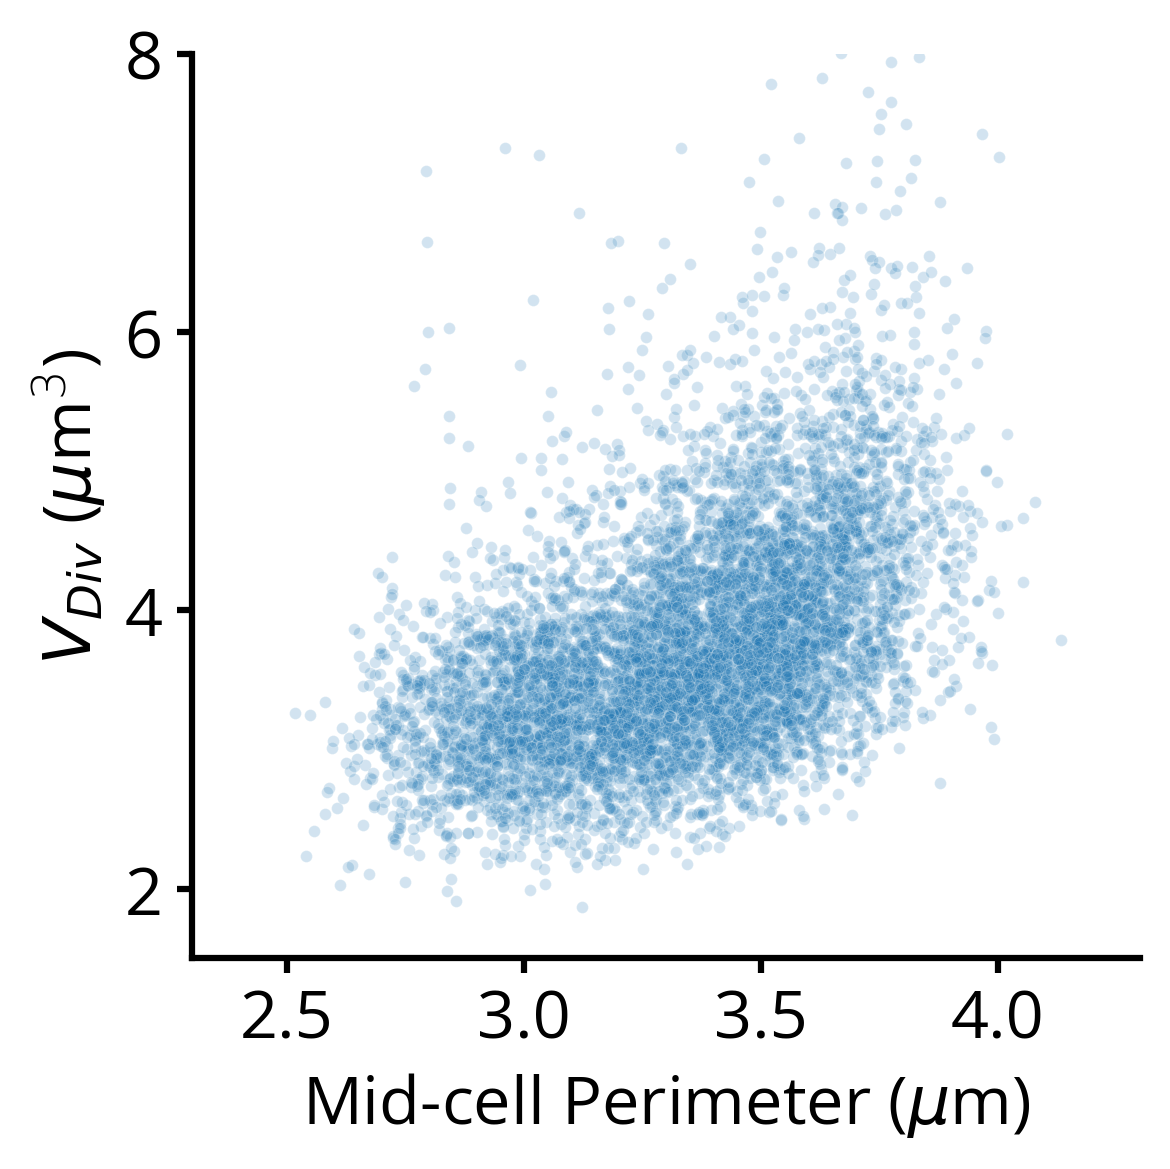

In [14]:
fig = plt.figure(figsize=(4,4))

sns.scatterplot(y=lDE26_cell_cycle_cell_wall_ss["Division: Volume"],x=lDE26_cell_cycle_cell_wall_ss["Division: Width"]*np.pi,s=8,alpha=0.2,zorder=-1)
# sns.scatterplot(data=lDE26_cell_cycle_wide_pre,y="Division: Length",x="Division: Width",s=3,alpha=0.5)
# plt.plot(width_series,const_length_model,color="grey",zorder=1,linewidth=2.5)
# plt.plot(width_series,const_sa_model,color="black",zorder=1,linewidth=2.5)
# plt.plot(width_series,const_vol_model,color="grey",zorder=1,linewidth=2.5)

# plt.text(width_series[-1]+0.01,const_length_model[-1]+0.01,"L",fontsize=tick_label_size,color="grey")
# plt.text(width_series[-1]+0.01,const_sa_model[-1]+0.01,"SA",fontsize=tick_label_size,color="black")
# plt.text(width_series[-1]+0.01,const_vol_model[-1]+0.01,"V",fontsize=tick_label_size,color="grey")

plt.ylim(1.5,8)
plt.xlim(2.3,4.3)

# plt.yscale("log",base=2)
# plt.xscale("log",base=2)

plt.ylabel(r'$V_{Div}$ ($\mu$m$^{3}$)',fontsize=16)
plt.xlabel("Mid-cell Perimeter ($\mu$m)",fontsize=16)
plt.yticks([2,4,6,8],["2","4","6","8"])
# plt.xticks([0.8,0.9,1.0,1.1,1.2],["0.8","0.9","1","1.1","1.2"])

sns.despine(right=True,top=True)

for spine in plt.gca().spines.values():
    spine.set_linewidth(1.5)

plt.tick_params(axis='both', labelsize=16, width=1.5)  # Set x-tick label size
plt.tick_params(axis='both', labelsize=16, width=1, length=3, which="minor")  # Set x-tick label size
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/S12/Volume_Width_Dependence.png",dpi=500,transparent=True,bbox_inches="tight")

## Figure S12C

In [16]:
## get WT growth rate from controls
wt_growth_rate = np.median(ss_estimators_df_controls_only["Instantaneous Growth Rate: Volume"])

## Normalizing FusA measurments to library
wt_volume = np.median(ss_estimators_df_controls_only["Volume"])
wt_width = np.median(ss_estimators_df_controls_only["Width"])

fusA_full_induction = all_fusA_isolate_df[all_fusA_isolate_df["Condition"] == "1uM AHL"]

growth_scaling_factor = wt_growth_rate/fusA_full_induction["Instantaneous Growth Rate: Volume"].iloc[0]
volume_scaling_factor = wt_volume/fusA_full_induction["Volume"].iloc[0]
width_scaling_factor = wt_width/fusA_full_induction["Width"].iloc[0]

all_fusA_isolate_df_scaled = all_fusA_isolate_df.copy()
all_fusA_isolate_df_scaled["Instantaneous Growth Rate: Volume"] = all_fusA_isolate_df_scaled["Instantaneous Growth Rate: Volume"]*growth_scaling_factor
all_fusA_isolate_df_scaled["Volume"] = all_fusA_isolate_df_scaled["Volume"]*volume_scaling_factor
all_fusA_isolate_df_scaled["Width"] = all_fusA_isolate_df_scaled["Width"]*width_scaling_factor


all_fusA_isolate_df_scaled["Volume Perimeter Norm"] = all_fusA_isolate_df_scaled["Volume"]/(2*np.pi*((all_fusA_isolate_df_scaled["Width"]/2)))
all_fusA_isolate_df_scaled["Volume Crosssection Norm"] = all_fusA_isolate_df_scaled["Volume"]/(np.pi*((all_fusA_isolate_df_scaled["Width"]/2)**2))
pheT_df["Volume Perimeter Norm"] = pheT_df["Volume"]/(2*np.pi*((pheT_df["Width"]/2)))
pheT_df["Volume Crosssection Norm"] = pheT_df["Volume"]/(np.pi*((pheT_df["Width"]/2)**2))
infA_df["Volume Perimeter Norm"] = infA_df["Volume"]/(2*np.pi*((infA_df["Width"]/2)))
infA_df["Volume Crosssection Norm"] = infA_df["Volume"]/(np.pi*((infA_df["Width"]/2)**2))
ss_estimators_df_controls_only["Volume Perimeter Norm"] = ss_estimators_df_controls_only["Volume"]/(2*np.pi*((ss_estimators_df_controls_only["Width"]/2)))
ss_estimators_df_controls_only["Volume Crosssection Norm"] = ss_estimators_df_controls_only["Volume"]/(np.pi*((ss_estimators_df_controls_only["Width"]/2)**2))

fusA_pheT_df = pd.concat([all_fusA_isolate_df_scaled,pheT_df])

/tmp/ipykernel_11893/1719605018.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheT_df["Volume Perimeter Norm"] = pheT_df["Volume"]/(2*np.pi*((pheT_df["Width"]/2)))
/tmp/ipykernel_11893/1719605018.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheT_df["Volume Crosssection Norm"] = pheT_df["Volume"]/(np.pi*((pheT_df["Width"]/2)**2))
/tmp/ipykernel_11893/1719605018.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

In [17]:
gene_dict = {gene_name:idx for idx,gene_name in enumerate(fusA_pheT_df["Gene"].unique())}
fusA_pheT_df["Gene Index"] = fusA_pheT_df["Gene"].apply(lambda x: gene_dict[x])

volume_vals = fusA_pheT_df["Volume"].values
volume_per_vals = fusA_pheT_df["Volume Perimeter Norm"].values
volume_cross_vals = fusA_pheT_df["Volume Crosssection Norm"].values
growth_vals = fusA_pheT_df["Instantaneous Growth Rate: Volume"].values

S0_init = 1.6
S0_lower_bound = 0
S0_upper_bound = np.inf

kappa_tRNA_init = 0.3
kappa_tRNA_lower_bound = 0
kappa_tRNA_upper_bound = 1

kappa_elong_init = -0.2
kappa_elong_lower_bound = -1
kappa_elong_upper_bound = 0

Isolate_Proteome_initial_guess = [S0_init,kappa_tRNA_init,kappa_elong_init]
Isolate_Proteome_bounds = [(S0_lower_bound,kappa_tRNA_lower_bound,kappa_elong_lower_bound),\
                           (S0_upper_bound,kappa_tRNA_upper_bound,kappa_elong_upper_bound)]

Proteome_popt, Proteome_pcov = curve_fit(partial(Proteome_scaling_global_wrapper, wt_growth_rate=wt_growth_rate),\
                                         fusA_pheT_df, volume_vals, \
                                         p0=Isolate_Proteome_initial_guess, bounds=Isolate_Proteome_bounds)
Proteome_log_likelihood,Proteome_R2 = compute_log_likelihood_and_R2_Proteome(fusA_pheT_df,volume_vals,Proteome_scaling_global,*Proteome_popt,\
                                                                            wt_growth_rate=wt_growth_rate)

S0_volume = Proteome_popt[0]
kappa_tRNA_volume = Proteome_popt[1]
kappa_elong_volume = Proteome_popt[2]
alpha_volume = get_alpha(kappa_tRNA_volume, kappa_elong_volume, wt_growth_rate)

Proteome_popt, Proteome_pcov = curve_fit(partial(Proteome_scaling_global_wrapper, wt_growth_rate=wt_growth_rate),\
                                         fusA_pheT_df, volume_per_vals, \
                                         p0=Isolate_Proteome_initial_guess, bounds=Isolate_Proteome_bounds)
Proteome_log_likelihood_per,Proteome_R2_per = compute_log_likelihood_and_R2_Proteome(fusA_pheT_df,volume_per_vals,Proteome_scaling_global,*Proteome_popt,\
                                                                            wt_growth_rate=wt_growth_rate)

S0_volume_per = Proteome_popt[0]
kappa_tRNA_volume_per = Proteome_popt[1]
kappa_elong_volume_per = Proteome_popt[2]
alpha_volume_per = get_alpha(kappa_tRNA_volume_per, kappa_elong_volume_per, wt_growth_rate)

Proteome_popt, Proteome_pcov = curve_fit(partial(Proteome_scaling_global_wrapper, wt_growth_rate=wt_growth_rate),\
                                         fusA_pheT_df, volume_cross_vals, \
                                         p0=Isolate_Proteome_initial_guess, bounds=Isolate_Proteome_bounds)
Proteome_log_likelihood_cross,Proteome_R2_cross = compute_log_likelihood_and_R2_Proteome(fusA_pheT_df,volume_cross_vals,Proteome_scaling_global,*Proteome_popt,\
                                                                            wt_growth_rate=wt_growth_rate)

S0_volume_cross = Proteome_popt[0]
kappa_tRNA_volume_cross = Proteome_popt[1]
kappa_elong_volume_cross = Proteome_popt[2]
alpha_volume_cross = get_alpha(kappa_tRNA_volume_cross, kappa_elong_volume_cross, wt_growth_rate)

-13.685646250549787
53.94942761352863
-0.1472999539688331


In [18]:
Proteome_R2,Proteome_R2_per,Proteome_R2_cross

(0.9754222565951761, 0.9737771189736492, 0.9716631290009368)

In [19]:
Proteome_log_likelihood,Proteome_log_likelihood_per,Proteome_log_likelihood_cross

(-13.685646250549787, 53.94942761352863, -0.1472999539688331)

/tmp/ipykernel_11893/3695157241.py:46: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 14)
/tmp/ipykernel_11893/3695157241.py:51: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 6)
/tmp/ipykernel_11893/3695157241.py:56: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 14)


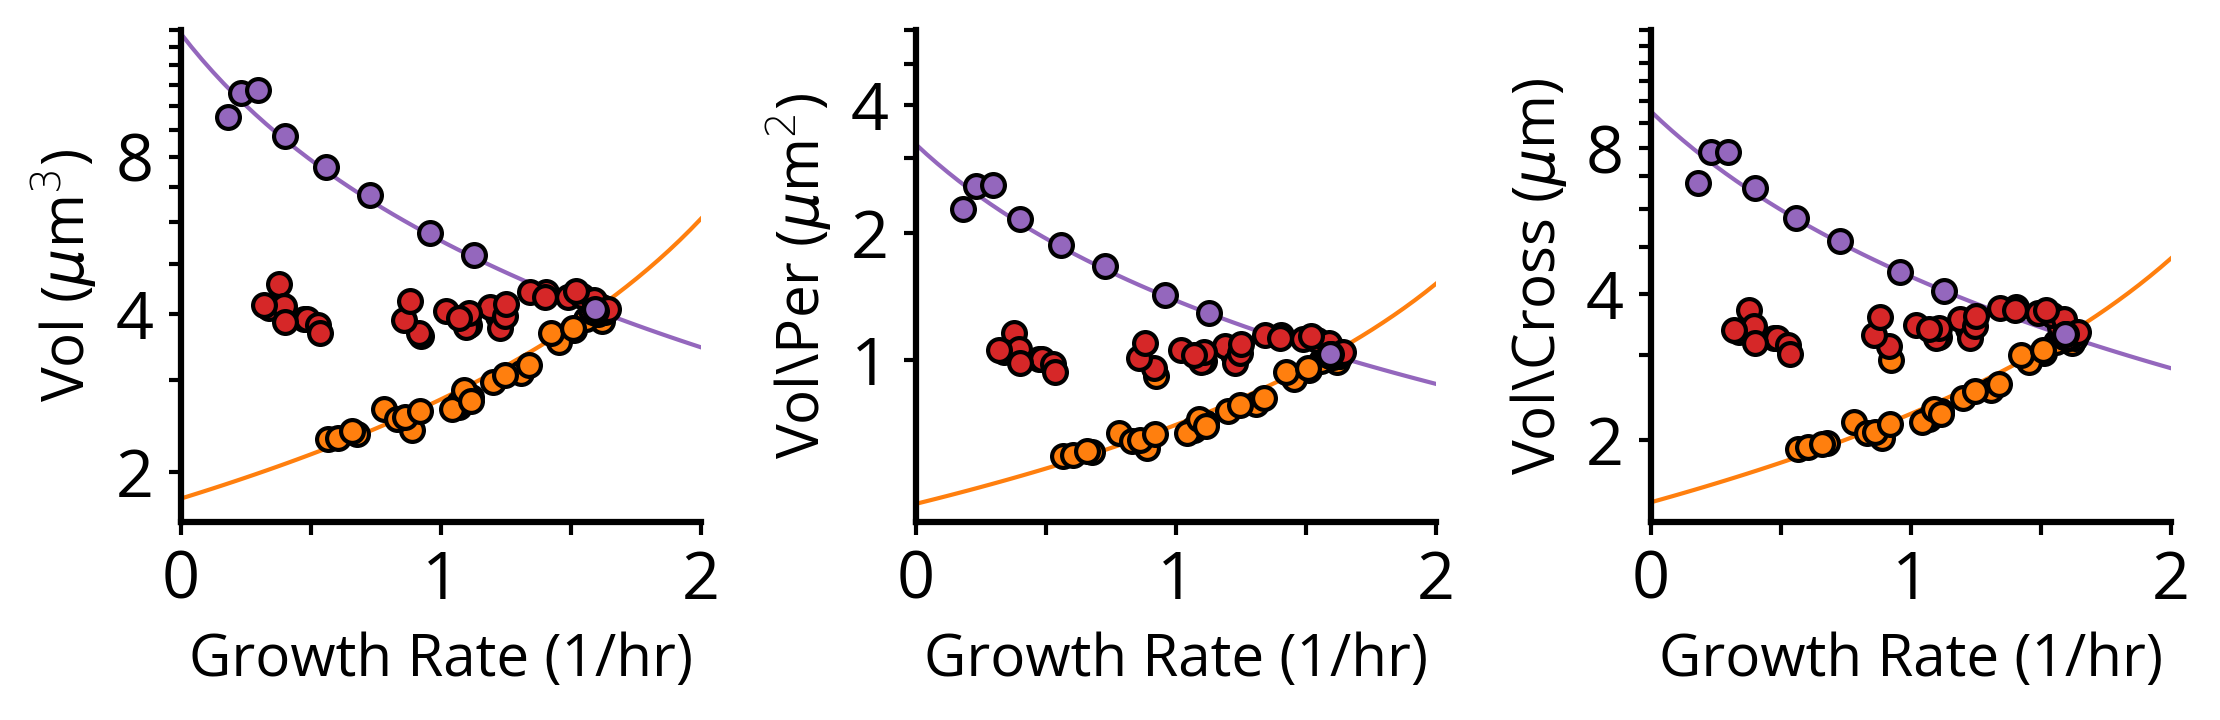

In [20]:
fig,_ = plt.subplots(1,3,figsize=(7.5,2.5))
# Set a light grey background

for i in range(3):
    ax = plt.subplot(1,3,i+1)

    if i == 0:
        fusA_volume_vals,pheT_volume_vals,infA_volume_vals = all_fusA_isolate_df_scaled["Volume"],pheT_df["Volume"],infA_df["Volume"]
        working_S0,kappa_elong,kappa_tRNA = S0_volume,kappa_elong_volume,kappa_tRNA_volume
        working_alpha = alpha_volume
    elif i == 1:
        fusA_volume_vals,pheT_volume_vals,infA_volume_vals = all_fusA_isolate_df_scaled["Volume Perimeter Norm"],pheT_df["Volume Perimeter Norm"],infA_df["Volume Perimeter Norm"]
        working_S0,kappa_elong,kappa_tRNA = S0_volume_per,kappa_elong_volume_per,kappa_tRNA_volume_per
        working_alpha = alpha_volume_per
    else:
        fusA_volume_vals,pheT_volume_vals,infA_volume_vals = all_fusA_isolate_df_scaled["Volume Crosssection Norm"],pheT_df["Volume Crosssection Norm"],infA_df["Volume Crosssection Norm"]
        working_S0,kappa_elong,kappa_tRNA = S0_volume_cross,kappa_elong_volume_cross,kappa_tRNA_volume_cross
        working_alpha = alpha_volume_cross
        
    
    plt.scatter(all_fusA_isolate_df_scaled["Instantaneous Growth Rate: Volume"],fusA_volume_vals,s=30,linewidth=1,edgecolor="black",color="tab:purple",zorder=-11)
    
    plt.plot(np.linspace(0, 2),
             Proteome_scaling(np.linspace(0, 2), kappa_elong, S0=working_S0, alpha=working_alpha),
             color="tab:purple",zorder=-15,linewidth=1)
    
    plt.scatter(pheT_df["Instantaneous Growth Rate: Volume"],pheT_volume_vals,s=30,linewidth=1,edgecolor="black",color="tab:orange",zorder=-12)
    
    plt.plot(np.linspace(0, 2),
             Proteome_scaling(np.linspace(0, 2), kappa_tRNA, S0=working_S0, alpha=1),
             color="tab:orange",zorder=-15,linewidth=1)
    
    plt.scatter(infA_df["Instantaneous Growth Rate: Volume"],infA_volume_vals,s=30,linewidth=1,edgecolor="black",color="tab:red",zorder=-12)
    
    # plt.plot(np.linspace(0, 2),
    #          np.repeat(Isolate_intersection_volume,len(np.linspace(0, 2))),
    #          color="tab:red",zorder=-15,linewidth=1)
    
    plt.xlabel("Growth Rate (1/hr)", fontsize=14)
    ax.set_yscale("log", base=2)

    if i == 0:
        plt.ylabel(r"Vol ($\mu$m$^{3}$)", fontsize=14)
        ax.set_yticks(ticks=[2, 4, 8, 16], labels=["2", "4", "8", "16"], minor=False)
        ax.set_yticks(ticks=[3, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15], labels=[], minor=True)
        plt.ylim(0, 14)
    elif i == 1:
        plt.ylabel(r"Vol\Per ($\mu$m$^{2}$)", fontsize=14)
        ax.set_yticks(ticks=[1, 2, 4], labels=["1", "2", "4"], minor=False)
        ax.set_yticks(ticks=[3, 5, 6], labels=[], minor=True)
        plt.ylim(0, 6)
    else:
        plt.ylabel(r"Vol\Cross ($\mu$m)", fontsize=14)
        ax.set_yticks(ticks=[2, 4, 8, 16], labels=["2", "4", "8", "16"], minor=False)
        ax.set_yticks(ticks=[3, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15], labels=[], minor=True)
        plt.ylim(0, 14)
    ax.set_xticks(ticks=[0, 1, 2], minor=False)
    ax.set_xticks(ticks=[0.5, 1.5], labels=[], minor=True)
    plt.xlim(0, 2)
    
    
    # Set spine thickness
    for spine in ax.spines.values():
        spine.set_linewidth(3)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)
    
    # Adjust tick parameters
    ax.tick_params(axis='both', direction='out', labelsize=16, width=1, length=3)
    ax.tick_params(axis='both', direction='out', labelsize=16, width=1, which='minor', length=3)
    
    # Remove top and right spines
    sns.despine(right=True, top=True)
    sns.despine()

plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/S12/Normalized_Size_Fits.png",dpi=500,transparent=True,bbox_inches="tight")